# Imports

In [164]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hidrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [191]:
def samplePos(M: int, beta: float, delta0: float = 0.5, Mmulti: int = 10) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = []

    # Starting position
    pos = np.array([0.1, 0.1, 0.1])
    rpos = np.sum(pos**2)**0.5
    samples += [rpos]

    lnpsinow = -beta * rpos

    delta = delta0

    # Metropolis Loop
    succ = 0
    for attempt in range(M * Mmulti):
        step = delta * (2 * np.random.random(size=(3)) - 1)
        posnext = pos + step
        rposnext = np.sum(posnext**2)**0.5
        lnpsinext = -beta * rposnext

        accept = min(1, np.exp(2 * (lnpsinext - lnpsinow)))
        test = np.random.random()

        # Accept step
        if accept > test:
            succ += 1
            pos = posnext
            rpos = rposnext
            lnpsinow = lnpsinext
            samples += [rpos]

            if succ >= M:
                print(f"Acceptance: {succ / attempt}")
                return np.array(samples)
    
    raise ValueError(f"Took a total of {M * Mmulti} steps but only {succ} were accepted!")

In [199]:
def sampleNeff(data: np.ndarray, k1percent: float = 0.0, ipercent: float = 0.4) -> int:
    N = len(data)
    k1 = int(k1percent * N)
    k2 = N-1

    icutoff = int(k2 * ipercent)
    Neq = k2 - k1 + 1

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) for i in range(1, Neq)]) / (var * (Neq - 1))
    timecorr = 1 + 2 * np.sum(autocorr[:icutoff] * (autocorr[:icutoff] > 0))

    Neff = Neq / timecorr
    print(f"Neff: {Neff}")

    return Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.9628036843287654
[5.31267951 5.24832427 5.1305098 ]
Neff: 14.574004739578216

Beta = 0.300
Acceptance: 0.9407632726018377
[2.20604746 2.07523543 2.2298673 ]
Neff: 22.349833751981453

Beta = 0.400
Acceptance: 0.9254974548819991
[3.93494512 3.89028143 4.29513802]
Neff: 40.20805243406317

Beta = 0.500
Acceptance: 0.9056603773584906
[0.8598371  0.81316926 0.99760312]
Neff: 39.30683226309233

Beta = 0.600
Acceptance: 0.8847469623687625
[3.08379952 2.73948133 3.02285835]
Neff: 40.58884580853782

Beta = 0.700
Acceptance: 0.8675284115554784
[1.87651189 1.68420281 1.80990524]
Neff: 53.1828493181321

Beta = 0.800
Acceptance: 0.8479846232121657
[1.61671398 1.74603928 1.77268425]
Neff: 67.98349557224753

Beta = 0.900
Acceptance: 0.8272210886229526
[0.52440088 0.69003546 0.69116565]
Neff: 60.62864611248691

Beta = 1.000
Acceptance: 0.8137358613394092
[1.88004013 1.7022841  1.45265591]
Neff: 62.427766573919435

Beta = 1.100
Acceptance: 0.796516567544605
[0.83600939 0.86697

Text(0.5, 1.0, 'Parameter Sweep')

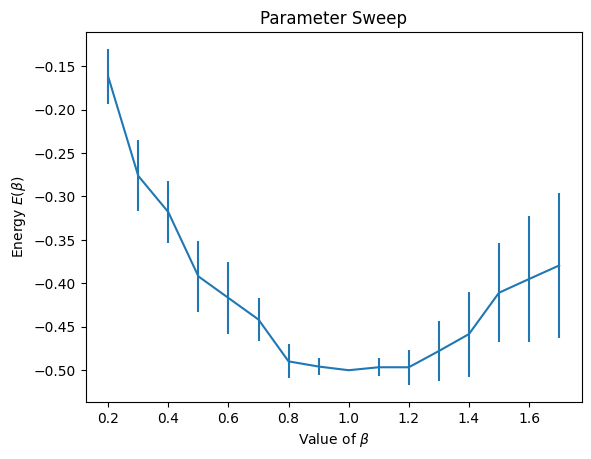

In [201]:
# Parameters
sampleM = 30000
discard = 10000

# Sweep Variational Parameter
betamin = 0.2
betamax = 1.7

Ebeta = []
Estd = []
bb = np.linspace(betamin, betamax, 16)
for beta in bb:
    print(f"Beta = {beta:.3f}")
    Rs = samplePos(sampleM, beta, delta0=0.4, Mmulti=20)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
    Estd += [np.std(El) / np.sqrt(Neff)]
    Ebeta += [np.average(El)]
    print("")

print(f"Best beta: {bb[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bb, Ebeta, yerr=Estd)
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

# With Reweighting

In [168]:
# Parameters
sampleM = 10000
discard = 1000
gamma = 0.01           # Gradient descent constant

# Starting Variational Parameters
beta0 = 1.1
beta1 = 1.2

delta0 = 1/beta
delta1 = 1/beta1

bb = [beta0, beta1]
Ebeta = []
Estd = []

# Want to minimize a function which is average(energy) + varW * std(energy) 
stdW = 0.01

# First run
beta = beta0
delta = delta0
Rs = samplePos(sampleM, beta, delta)
Rs = Rs[discard:]
El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
Estd += [np.std(El) / np.sqrt(len(Rs))]
Ebeta += [np.average(El)]
func0 = np.average(El) + stdW * np.std(El) / np.sqrt(sampleM)

beta = beta1
delta = delta1
Rs = samplePos(sampleM, beta, delta)
Rs = Rs[discard:]
El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
Estd += [np.std(El) / np.sqrt(len(Rs))]
Ebeta += [np.average(El)]
func1 = np.average(El) + stdW * np.std(El) / np.sqrt(sampleM)

while True:
    # Do gradient descent
    beta2 = beta1 - gamma * (func1 - func0) / (beta1 - beta0)

    # Calculate weights
    ww = np.exp(-2 * beta2 * Rs) / np.exp(-2 * beta2 * Rs)

    # Effective points should be high enough
    m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)

    print(m, beta1, beta2)
    print(ww)
    print(np.sum(ww**2))
    print((np.sum(ww))**2)
    if m < 0.5:
        break

    # New energy
    El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
    bb += [beta2]
    Estd += [np.std(El) / np.sqrt(sampleM)]
    Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    func2 = Ebeta[-1] + stdW * np.std(El) / np.sqrt(sampleM)

    # Next step
    beta0 = beta1
    beta1 = beta2

    func0 = func1
    func1 = func2

print(f"Final beta: {beta1}")

plt.errorbar(bb, Ebeta, yerr=Estd)
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

Acceptance: 0.7046223224351748
Acceptance: 0.5663797009515179
1.0 1.2 1.2004819691528295
[1. 1. 1. ... 1. 1. 1.]
9001.0
81018001.0
1.0 1.2004819691528295 1.2004819691528295
[1. 1. 1. ... 1. 1. 1.]
9001.0
81018001.0
nan 1.2004819691528295 nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan

/tmp/ipykernel_1672/2371399216.py:41: RuntimeWarning: invalid value encountered in scalar divide
  beta2 = beta1 - gamma * (func1 - func0) / (beta1 - beta0)


nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan


KeyboardInterrupt: 

Beta = 
0.2
Mean = 
-0.17091662491965462
Correlated Error = 
0.12678195013166707
Acceptance Rate = 
0.9044391389585075
Cut off ratio (M / K) = 
6.276224885016767
Uncorrelated Error estimate = 
0.0075440042182348096
Correlation time = 
47.799434452419014
     
Beta = 
0.30000000000000004
Mean = 
-0.2609142661670057
Correlated Error = 
0.2363544872403858
Acceptance Rate = 
0.8576746118257813
Cut off ratio (M / K) = 
8.85280817695747
Uncorrelated Error estimate = 
0.011841782171120904
Correlation time = 
33.887552288872016
     
Beta = 
0.4
Mean = 
-0.3276158229614471
Correlated Error = 
0.24009794782112717
Acceptance Rate = 
0.8119269950227459
Cut off ratio (M / K) = 
11.17911358636635
Uncorrelated Error estimate = 
0.010704798743781545
Correlation time = 
26.835759175563734
     
Beta = 
0.5
Mean = 
-0.37726314009918577
Correlated Error = 
0.24851733093500733
Acceptance Rate = 
0.7679676478225013
Cut off ratio (M / K) = 
13.121462793575578
Uncorrelated Error estimate = 
0.01022726000669

/tmp/ipykernel_1672/3965575736.py:61: RuntimeWarning: invalid value encountered in scalar divide
  K = 1+2*sum/v


Cut off ratio (M / K) = 
nan
Uncorrelated Error estimate = 
nan
Correlation time = 
nan
     
Beta = 
1.1
Mean = 
-0.4885737674216948
Correlated Error = 
0.12962304938915659
Acceptance Rate = 
0.5356592645602919
Cut off ratio (M / K) = 
12.621996521537701
Uncorrelated Error estimate = 
0.005438910960036335
Correlation time = 
23.76803063509733
     
Beta = 
1.2
Mean = 
-0.4860869075867473
Correlated Error = 
0.22811151682411426
Acceptance Rate = 
0.5115739436470924
Cut off ratio (M / K) = 
24.12816700795358
Uncorrelated Error estimate = 
0.006922752264193404
Correlation time = 
12.433600940390887
     
Beta = 
1.3
Mean = 
-0.4535422948219682
Correlated Error = 
0.3360106991141992
Acceptance Rate = 
0.4746148246531026
Cut off ratio (M / K) = 
18.2192553464218
Uncorrelated Error estimate = 
0.011734957958632174
Correlation time = 
16.46609558380875
     
Beta = 
1.4000000000000001
Mean = 
-0.44325003747963515
Correlated Error = 
0.542234742577605
Acceptance Rate = 
0.45039187364839056
Cu

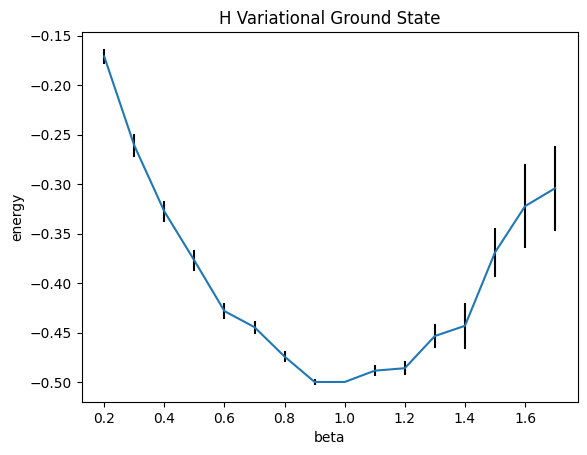

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, log, exp, mean, var
from random import random as rand
# h = -1/2 \nabla^2 - 1/r, psi=exp(-\beta r)

# Wave function of the form exp(-beta*r)

# First we create a random walk
def rad(x,y,z):
    return sqrt(x*x + y*y + z*z)

def monte_carlo(beta):
    N = 15000 # num of steps
    t_eq = 1500 # num of steps to equilibrate
    rand_walk = np.zeros((N - t_eq, 2), dtype = float)
    delta = 2
    x,y,z = 10.0, 0.1, 0.01
    r = rad(x,y,z)
    logpsi = -beta*r
    ekin = -0.5*beta*(beta-2/r)
    epot =-1.0/r
    etot = ekin + epot
    for i in range(N):
        xp = x + delta*(rand() - 0.5)
        yp = y + delta*(rand() - 0.5)
        zp = z + delta*(rand() - 0.5)
        rp = rad(xp,yp,zp)
        logpsip = -beta*rp
        p = min(1, exp(2*(logpsip - logpsi)))
        if p > rand():
            x = xp
            y = yp
            z = zp
            r = rp
            logpsi = -beta*r
            ekin=-0.5*beta*(beta-2/r)
            epot=-1.0/r
            etot=ekin+epot
        if i < t_eq:
            continue
        rand_walk[i-t_eq] = [p, etot]
    return rand_walk

# Now we process the data to remove autocorrelation

def offset_corr(arr, N, a, i):
    sum = 0
    for j in range(N-i):
        sum += (arr[j]-a)*(arr[j+i] - a)
    return sum / (N - i)

def corr_time(arr):
    N = len(arr)
    a = np.mean(arr)
    v = np.var(arr, ddof = 1)
    M = 300 # cut off
    sum = 0
    for i in range(100): # HERE DECIDE CUTOFF ON i.
        sum += offset_corr(arr, N, a, i)
    K = 1+2*sum/v
    err = np.sqrt(v*abs(K)/N)
    print("Cut off ratio (M / K) = ")
    print(M / K)
    print("Uncorrelated Error estimate = ")
    print(err)
    print("Correlation time = ")
    print(K)
    return err

def reblock(arr):
    K = corr_time(arr)
    print(K)
    if K <= 0:
        print("!! Corr time < 0 !!")
    return arr[::abs(int(K))]

"""
b_vals = np.linspace(0, 5, 26)
E_arr = np.zeros(26)
for i in range(26):
    beta = b_vals[i]
    arr = monte_carlo(beta)
    E_arr[i] = np.mean(arr[:,1])
    
plt.plot(b_vals, E_arr)
plt.show()
"""


def main(test_values):
    L = len(test_values)
    E_vals = np.zeros(L)
    errors = np.zeros(L)
    for i in range(L):
        beta = test_values[i]
        arr = monte_carlo(beta)

        print("Beta = ")
        print(beta)

        E = np.mean(arr[:,1])
        print("Mean = ")
        print(E)

        print("Correlated Error = ")
        print(np.std(arr[:,1], ddof = 1))

        print("Acceptance Rate = ")
        print(np.mean(arr[:,0]))

        E_vals[i] = E
        errors[i] = corr_time(arr[:,1])

        print("     ")

    plt.errorbar(test_values, E_vals, yerr = errors, ecolor = 'black')
    plt.title("H Variational Ground State")
    plt.xlabel("beta")
    plt.ylabel("energy")
    plt.show()
        
"""
arr = monte_carlo(1.3)
print("Acceptance rate is: " + str(np.mean(arr[:,0])))
evals = arr[:,1]
print(evals)
print(corr_time(evals))
print(np.var(evals,ddof=1))
"""

test = np.linspace(betamin, betamax, 16)

main(test)
